#Needs finetuning or data engineering...

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

import xgboost

## Loading Data

In [ ]:
data = pd.read_csv("hotel_booking.csv")

## Understanding the Data

In [ ]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
data.isna().sum().sort_values(ascending=False)

company                           112593
agent                              16340
country                              488
children                               4
hotel                                  0
booking_changes                        0
deposit_type                           0
days_in_waiting_list                   0
customer_type                          0
adr                                    0
reserved_room_type                     0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
reservation_status_date                0
name                                   0
email                                  0
phone-number                           0
assigned_room_type                     0
previous_bookings_not_canceled         0
is_canceled                            0
previous_cancellations                 0
is_repeated_guest                      0
distribution_channel                   0
market_segment  

## Data Preparation


As mentioned in our proposal, we will remove 'email', 'credit_card','phone-number' and 'name' from our dataset. We can use 'is_repeated_guest' instead.

In [ ]:
data.drop(['email', 'credit_card', 'phone-number', 'name'], axis=1, inplace = True)

### Modifying date columns

Set the 'arrival_date_month' values to numbers instead of month names. Convert 'reservation_status_date' to datetime.

In [ ]:
data['arrival_date_month'] = pd.to_datetime(data.arrival_date_month, format='%B').dt.month
data['reservation_status_date']=data['reservation_status_date'].astype('datetime64[ns]')

### Dealing with empty values

There are too many missing values for 'company' and 'agent'. We will remove these columns from our dataset. 'children' is only missing 4 values. We will set these to the median value. The missing values for country will be the mode. We will only use this column for some analysis to see if there is anything interesting, however, as mentioned in our proposal it will be deleted from our model.

In [ ]:
data.drop(['agent', 'company'], axis=1, inplace = True)

array([[<Axes: title={'center': 'children'}>]], dtype=object)

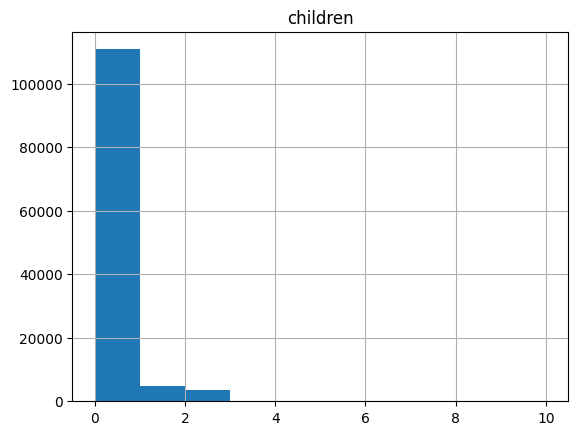

In [ ]:
data.hist(column='children')

In [ ]:
data['children'].fillna(data['children'].median(), inplace=True)
data['children']=data['children'].astype(int)

### Setting categorical data to numerical

In [ ]:
def factorize_columns(data, columns_to_factorize):
    encoded_mappings = {}

    for column in columns_to_factorize:
        codes, unique_values = pd.factorize(data[column])
        data[column] = codes
        encoded_mappings[column] = {'codes': codes, 'unique_values': unique_values}

    return data, encoded_mappings

In [ ]:
def replace_undefined_with_mode(data, column_name):
    mode_value = data[column_name].mode()[0]  # Get the mode (most frequent value)

    # Replace "undefined" values with the mode
    data[column_name] = data[column_name].replace('', mode_value)

    return data

In [ ]:
data.isna().sum().sort_values(ascending=False)

hotel                             0
is_canceled                       0
reservation_status                0
total_of_special_requests         0
required_car_parking_spaces       0
adr                               0
customer_type                     0
days_in_waiting_list              0
deposit_type                      0
booking_changes                   0
assigned_room_type                0
reserved_room_type                0
previous_bookings_not_canceled    0
previous_cancellations            0
is_repeated_guest                 0
distribution_channel              0
market_segment                    0
country                           0
meal                              0
babies                            0
children                          0
adults                            0
stays_in_week_nights              0
stays_in_weekend_nights           0
arrival_date_day_of_month         0
arrival_date_week_number          0
arrival_date_month                0
arrival_date_year           

In [ ]:
data, mappings = factorize_columns(data, ['hotel','meal','market_segment','distribution_channel','reserved_room_type','assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status'])

In [ ]:
for column, mapping in mappings.items():

    print("Unique values:", mapping['unique_values'])

Unique values: Index(['Resort Hotel', 'City Hotel'], dtype='object')
Unique values: Index(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype='object')
Unique values: Index(['Direct', 'Corporate', 'Online TA', 'Offline TA/TO', 'Complementary',
       'Groups', 'Undefined', 'Aviation'],
      dtype='object')
Unique values: Index(['Direct', 'Corporate', 'TA/TO', 'Undefined', 'GDS'], dtype='object')
Unique values: Index(['C', 'A', 'D', 'E', 'G', 'F', 'H', 'L', 'P', 'B'], dtype='object')
Unique values: Index(['C', 'A', 'D', 'E', 'G', 'F', 'I', 'B', 'H', 'P', 'L', 'K'], dtype='object')
Unique values: Index(['No Deposit', 'Refundable', 'Non Refund'], dtype='object')
Unique values: Index(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype='object')
Unique values: Index(['Check-Out', 'Canceled', 'No-Show'], dtype='object')


##Data Analysis

### Check outliers

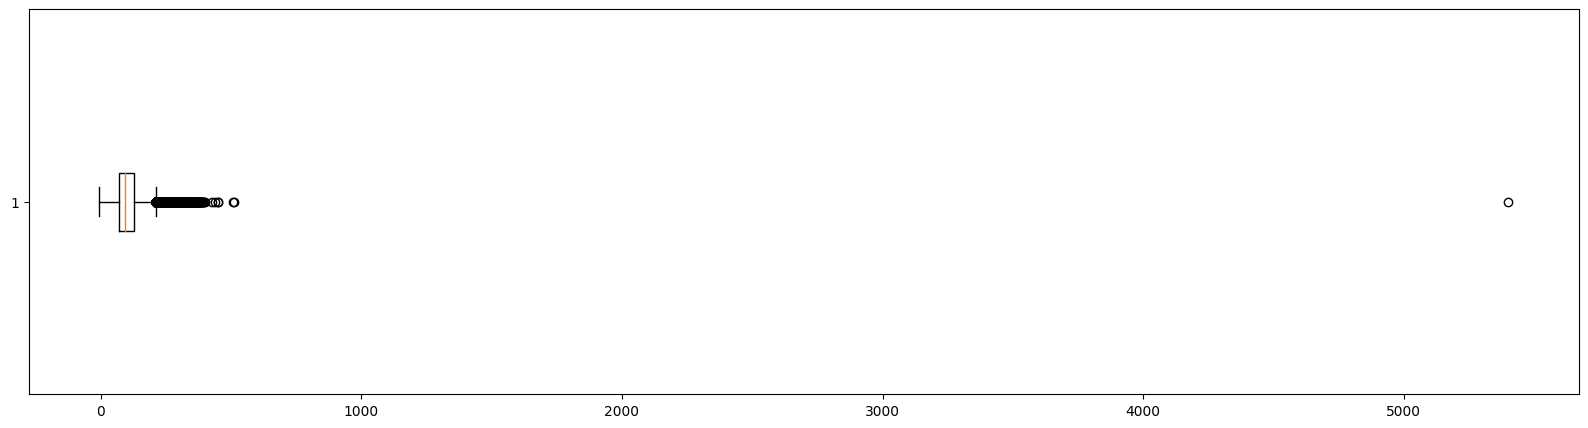

In [ ]:
fig = plt.figure(figsize =(20, 5))
plt.boxplot(data['adr'], vert=False)
plt.show()

In [ ]:
data.drop(data['adr'].idxmax(), inplace = True)

### Visualizations

In [ ]:
cancelled_percentage = data["is_canceled"].value_counts(normalize = True)
data['total_revenues'] = data['adr'] * (data['stays_in_weekend_nights'] + data['stays_in_week_nights'])
print(cancelled_percentage)

0    0.629589
1    0.370411
Name: is_canceled, dtype: float64


In [ ]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_revenues
0,0,0,342,2015,7,27,1,0,0,2,...,3,0,0,0,0.0,0,0,0,2015-07-01,0.0
1,0,0,737,2015,7,27,1,0,0,2,...,4,0,0,0,0.0,0,0,0,2015-07-01,0.0
2,0,0,7,2015,7,27,1,0,1,1,...,0,0,0,0,75.0,0,0,0,2015-07-02,75.0
3,0,0,13,2015,7,27,1,0,1,1,...,0,0,0,0,75.0,0,0,0,2015-07-02,75.0
4,0,0,14,2015,7,27,1,0,2,2,...,0,0,0,0,98.0,0,1,0,2015-07-03,196.0


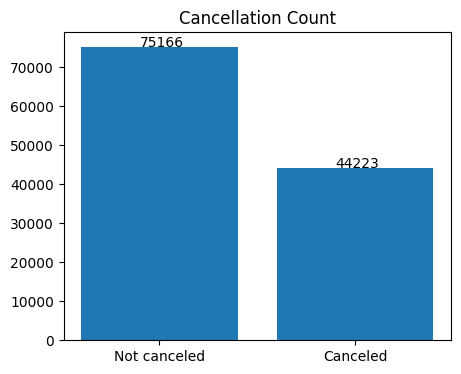

In [ ]:
plt.figure(figsize=(5, 4))
plt.title("Cancellation Count")
is_canceled_counts = data["is_canceled"].value_counts()

bars = plt.bar(["Not canceled", "Canceled"], is_canceled_counts)
for bar, count in zip(bars, is_canceled_counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, str(count), fontsize=10)


<function matplotlib.pyplot.show(close=None, block=None)>

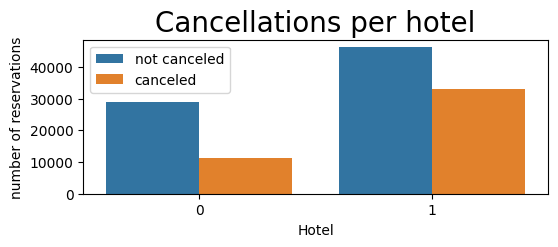

In [ ]:
plt.figure(figsize = (6,2))
ax1= sns.countplot(x = "hotel", hue = "is_canceled", data = data)
legend_labels,_ = ax1.get_legend_handles_labels()
ax1.legend(bbox_to_anchor=(1,1))
plt.title("Cancellations per hotel", size = 20)
plt.xlabel("Hotel")
plt.ylabel("number of reservations")
plt.legend(["not canceled", "canceled"])
plt.show

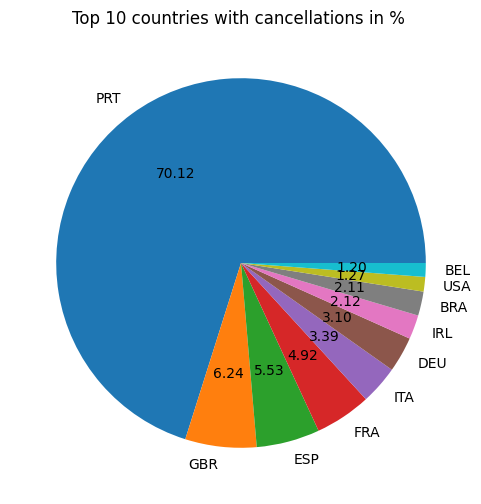

In [ ]:
cancelled_data = data[data['is_canceled'] == 1]
top_10_countries_canceled = cancelled_data['country'].value_counts()[:10]
plt.figure(figsize = (6,6))
plt.title("Top 10 countries with cancellations in % ")
plt.pie(top_10_countries_canceled, autopct = "%.2f", labels = top_10_countries_canceled.index)
plt.show()

In [ ]:
lost_revenues = cancelled_data['total_revenues'].sum()
print(lost_revenues)

16721837.120000001


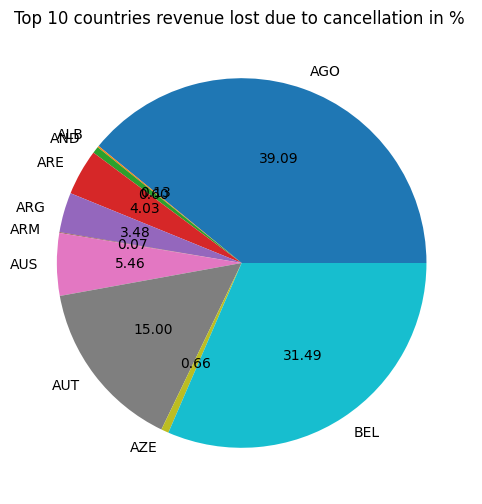

In [ ]:
top_10_countries_canceled_revenues = cancelled_data.groupby('country')['total_revenues'].sum()[:10]
plt.figure(figsize = (6,6))
plt.title("Top 10 countries revenue lost due to cancellation in % ")
plt.pie(top_10_countries_canceled_revenues,autopct = "%.2f",labels = top_10_countries_canceled_revenues.index)
plt.show()

In [ ]:
current_revenues = data[data['is_canceled'] == 0]['total_revenues'].sum()
print(current_revenues)

25996260.409999996


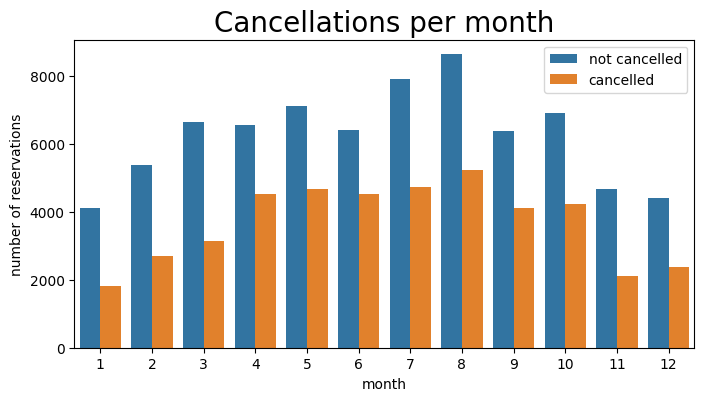

In [ ]:

plt.figure(figsize=(8,4))
ax1=sns.countplot(x = 'arrival_date_month', data=data, hue='is_canceled')
legend_labels,_=ax1.get_legend_handles_labels()
ax1.legend(bbox_to_anchor=[1,1])
plt.title("Cancellations per month", size=20)
plt.xlabel('month')
plt.ylabel('number of reservations')
plt.legend(['not cancelled','cancelled'])
plt.show()

In [ ]:
data[data['is_canceled'] == 0]['is_repeated_guest'].sum()

3258

In [ ]:
data['total_stay_in_nights'] = data['stays_in_week_nights'] + data['stays_in_weekend_nights']


In [ ]:
data[data['is_canceled'] == 0]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_revenues,total_stay_in_nights
0,0,0,342,2015,7,27,1,0,0,2,...,0,0,0,0.00,0,0,0,2015-07-01,0.00,0
1,0,0,737,2015,7,27,1,0,0,2,...,0,0,0,0.00,0,0,0,2015-07-01,0.00,0
2,0,0,7,2015,7,27,1,0,1,1,...,0,0,0,75.00,0,0,0,2015-07-02,75.00,1
3,0,0,13,2015,7,27,1,0,1,1,...,0,0,0,75.00,0,0,0,2015-07-02,75.00,1
4,0,0,14,2015,7,27,1,0,2,2,...,0,0,0,98.00,0,1,0,2015-07-03,196.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,1,0,23,2017,8,35,30,2,5,2,...,0,0,0,96.14,0,0,0,2017-09-06,672.98,7
119386,1,0,102,2017,8,35,31,2,5,3,...,0,0,0,225.43,0,2,0,2017-09-07,1578.01,7
119387,1,0,34,2017,8,35,31,2,5,2,...,0,0,0,157.71,0,4,0,2017-09-07,1103.97,7
119388,1,0,109,2017,8,35,31,2,5,2,...,0,0,0,104.40,0,0,0,2017-09-07,730.80,7


Text(0.5, 1.0, 'Average Daily rate by month')

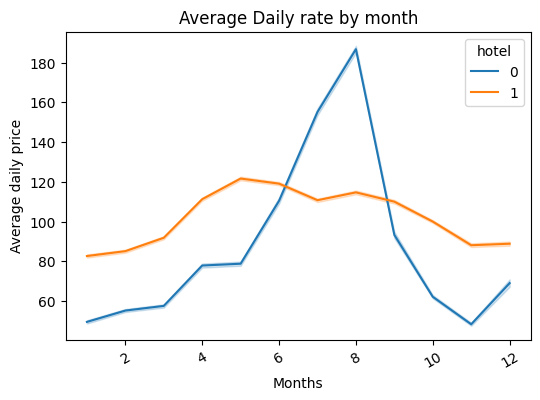

In [ ]:
plt.figure(figsize=(6,4))
sns.lineplot(x='arrival_date_month', y='adr', hue='hotel', data=data)
plt.ylabel("Average daily price")
plt.xlabel("Months")
p = plt.xticks(rotation=30)
plt.title("Average Daily rate by month")

In [ ]:
data.drop(['country','total_revenues','total_stay_in_nights'], axis=1, inplace = True)

## Modeling the data



In [ ]:
def RMSE(y,y_pred):
  mse=mean_squared_error(y, y_pred)
  return np.sqrt(mse)

In [ ]:
y = data[['adr']]
X = data.drop(['adr', 'reservation_status_date'],axis=1)

X

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,reservation_status
0,0,0,342,2015,7,27,1,0,0,2,...,0,0,0,3,0,0,0,0,0,0
1,0,0,737,2015,7,27,1,0,0,2,...,0,0,0,4,0,0,0,0,0,0
2,0,0,7,2015,7,27,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0
3,0,0,13,2015,7,27,1,0,1,1,...,0,1,1,0,0,0,0,0,0,0
4,0,0,14,2015,7,27,1,0,2,2,...,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,1,0,23,2017,8,35,30,2,5,2,...,0,1,1,0,0,0,0,0,0,0
119386,1,0,102,2017,8,35,31,2,5,3,...,0,3,3,0,0,0,0,0,2,0
119387,1,0,34,2017,8,35,31,2,5,2,...,0,2,2,0,0,0,0,0,4,0
119388,1,0,109,2017,8,35,31,2,5,2,...,0,1,1,0,0,0,0,0,0,0


### Create train and test data

In [ ]:
Xtrain, Xrest, ytrain, yrest = train_test_split(X, y, test_size=0.2)
Xval, Xtest, yval, ytest = train_test_split(Xrest, yrest, test_size=0.5)

In [ ]:
Xtrain['children'].fillna(Xtrain['children'].median(), inplace=True)
Xtest['children'].fillna(Xtest['children'].median(), inplace=True)
Xtrain['children']=Xtrain['children'].astype(int)
Xtest['children']=Xtest['children'].astype(int)

### Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(Xtrain, ytrain)

LinearRegression()

###Feature importance

['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status']
[14.536815655154621, 15.123107758174523, -0.055201399153575297, 16.669309711682335, 31.72124850678302, -6.437340467173958, 1.111935758579898, 0.21825488282388375, 1.170443311224496, 16.409408536729217, 28.370334731978158, 6.186916029913023, 2.9866129163389186, -6.716349870462603, 5.153168180878316, -24.383862462690143, -0.2799619553067352, -0.541324443828274, 5.610072108675023, 0.2554419302999074, 0.8982106166055723, 4.936437033334781, 0.0310

Text(0, 0.5, 'Features')

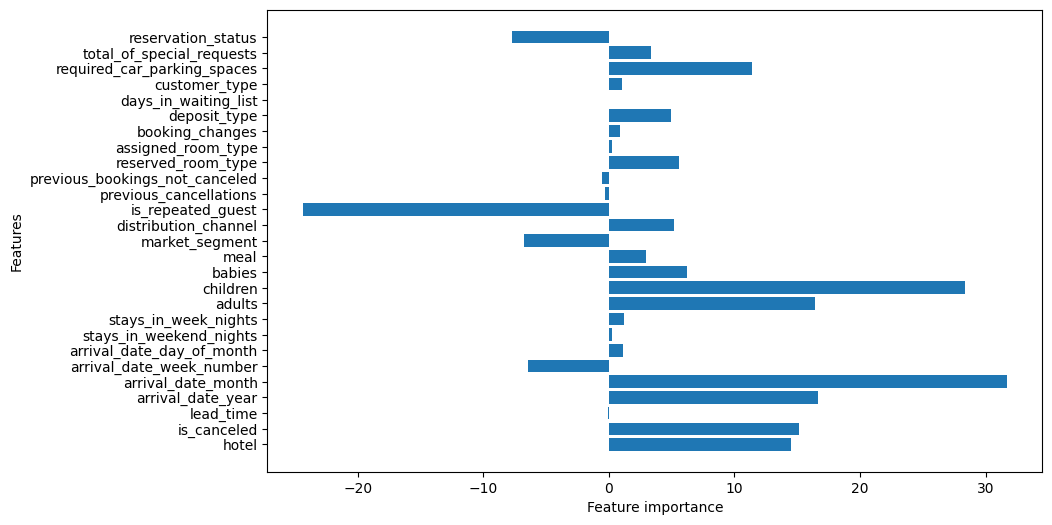

In [ ]:
import matplotlib.pyplot as plt

columns = Xtrain.columns.values.tolist()
print(columns)
coefs = lr.coef_.ravel().tolist()
print(coefs)

plt.figure(figsize = (10,6))
plt.barh(columns, coefs)
plt.xlabel("Feature importance")
plt.ylabel("Features")

In [ ]:
X.drop(["is_repeated_guest"], axis=1, inplace = True)

Text(0, 0.5, 'Features')

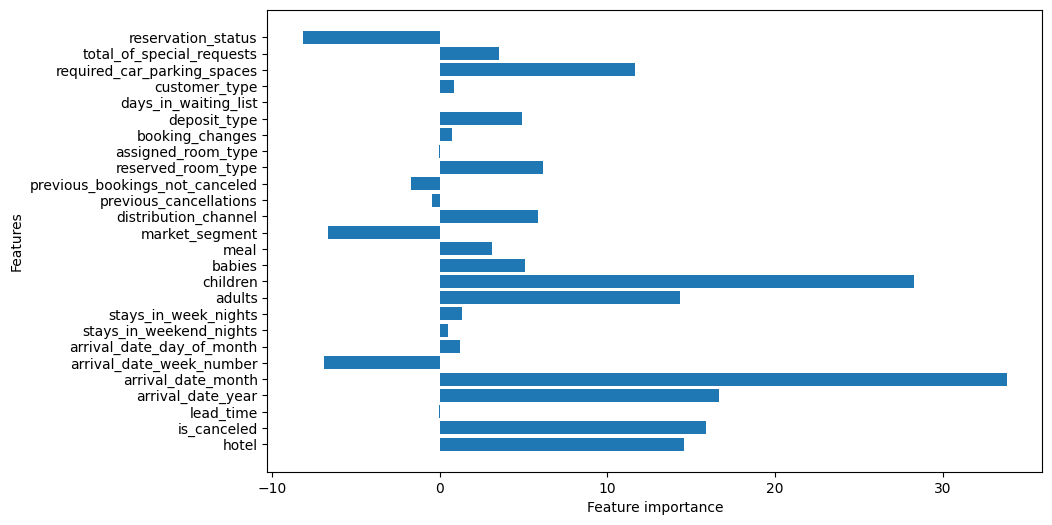

In [ ]:
Xtrain, Xrest, ytrain, yrest = train_test_split(X, y, test_size=0.2)
Xval, Xtest, yval, ytest = train_test_split(Xrest, yrest, test_size=0.5)
lr.fit(Xtrain, ytrain)

columns = Xtrain.columns.values.tolist()
coefs = lr.coef_.ravel().tolist()

plt.figure(figsize = (10,6))
plt.barh(columns, coefs)
plt.xlabel("Feature importance")
plt.ylabel("Features")

In [ ]:
lr.fit(Xtrain, ytrain)

LinearRegression()

###Model evaluation

In [ ]:
def calculate_relative_error(rmse, range):
    relative_error = float((rmse/range.item()) * 100)

    return relative_error

In [ ]:
y_range = y.max() - y.min()

In [ ]:
y_pred_lr = lr.predict(Xval)
rmse_val = RMSE(yval, y_pred_lr)
relative_error = calculate_relative_error(rmse_val, y_range)

print("Relative error for the average daily revenue:",relative_error)

Relative error for the average daily revenue: 7.6088425908909185


#### Cross validation

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = cross_val_score(lr, Xtrain, ytrain, cv=kf, scoring='neg_root_mean_squared_error')
print(" Cross validated RMSE:", -rmse_scores.mean())

 Cross validated RMSE: 39.07814852481674


###Fine tuning

In [ ]:
scorer = make_scorer(lambda yval, y_pred_lr: RMSE(yval, y_pred_lr), greater_is_better=False)
grid_search = GridSearchCV(lr, {'fit_intercept': [True, False]}, scoring=scorer, cv=5)

In [ ]:
grid_search.fit(Xtrain, ytrain)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated RMSE:", -grid_search.best_score_)

best_lr = grid_search.best_estimator_

yval_pred = best_lr.predict(Xval)
rmse_val = RMSE(yval, yval_pred)
relative_error_val = (rmse_val / y_range) * 100
print("Relative Error on Validation Set:", relative_error_val)

Best Parameters: {'fit_intercept': True}
Best Cross-Validated RMSE: 39.149145476412706
Relative Error on Validation Set: adr    7.608843
dtype: float64


###Final training

In [ ]:
rmse_lr = RMSE(ytest, y_pred_lr)
best_lr = LinearRegression(fit_intercept=grid_search.best_params_['fit_intercept'])
best_lr.fit(Xtrain, ytrain)
y_pred_lr = best_lr.predict(Xtest)

relative_error_lr = calculate_relative_error(rmse_lr, y_range)

print("Relative Error on Test Set:", relative_error_lr)

Relative Error on Test Set: 10.736989241147324


In [ ]:
print("RMSE on Test Set:", rmse_lr)

RMSE on Test Set: 55.44366504343655


### XGBOOST

In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(Xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

###Model evaluation

In [ ]:
y_pred_xgb = xgb.predict(Xval)
rmse_val = RMSE(yval, y_pred_xgb)
relative_error = calculate_relative_error(rmse_val, y_range)

print("Relative error for the average daily revenue:", relative_error)

Relative error for the average daily revenue: 3.397971674637413


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = cross_val_score(xgb, Xtrain, ytrain, cv=kf, scoring='neg_root_mean_squared_error')

print("Cross validated RMSE:", -rmse_scores.mean())

Cross validated RMSE: 17.277131520179495


In [ ]:
rmse_xgb = RMSE(ytest, y_pred_xgb)
print("RMSE on Test Set:", rmse_xgb)

RMSE on Test Set: 65.76039905804748


Discrepancy between CV RMSE and RMSE suggests overfitting

###Fine tuning

In [ ]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

grid_search = GridSearchCV(xgb, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(Xtrain, ytrain)

best_xgb = grid_search.best_estimator_

###Final training

In [ ]:
y_pred_xgb = best_xgb.predict(Xtest)

In [ ]:
rmse_xgb = RMSE(ytest, y_pred_xgb)
relative_error_xgb = calculate_relative_error(rmse_xgb, y_range)

print("Relative error for the average daily revenue:", relative_error_xgb)
print("RMSE on Test Set:", rmse_xgb)

Relative error for the average daily revenue: 3.189576685426326
RMSE on Test Set: 16.470336088204462


### KNN

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(Xtrain, ytrain)

KNeighborsRegressor()

###Model Evaluation

In [ ]:
y_pred_knn = knn.predict(Xval)
rmse_val = RMSE(yval, y_pred_knn)
relative_error = calculate_relative_error(rmse_val, y_range)

print("Relative error for the average daily revenue", relative_error)

Relative error for the average daily revenue 6.076263351433871


In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = cross_val_score(knn, Xtrain, ytrain, cv=kf, scoring='neg_root_mean_squared_error')

print("Cross validated RMSE:", -rmse_scores.mean())

Cross validated RMSE: 31.687184236293916


In [ ]:
rmse_knn = RMSE(ytest, y_pred_knn)
print("RMSE on Test Set:", rmse_knn)

RMSE on Test Set: 60.743873340767735


In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
scorer = make_scorer(lambda yval, y_pred_knn: RMSE(yval, y_pred_knn), greater_is_better=False)
grid_search = GridSearchCV(knn, param_grid, scoring=scorer, cv=5)

grid_search.fit(Xtrain, ytrain)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated  RMSE:", -grid_search.best_score_)

best_knn = grid_search.best_estimator_

Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Cross-Validated  RMSE: 26.56819697098672


###Final training

In [ ]:
y_pred_knn = best_knn.predict(Xtest)

rmse_knn = RMSE(ytest, y_pred_knn)
relative_error_knn = calculate_relative_error(rmse_knn, y_range)

print("RMSE on Test Set:", rmse_knn)
print("Relative error for the average daily revenue:", relative_error_knn)

RMSE on Test Set: 25.386001887187465
Relative error for the average daily revenue: 4.916147388974682


###Conclusion

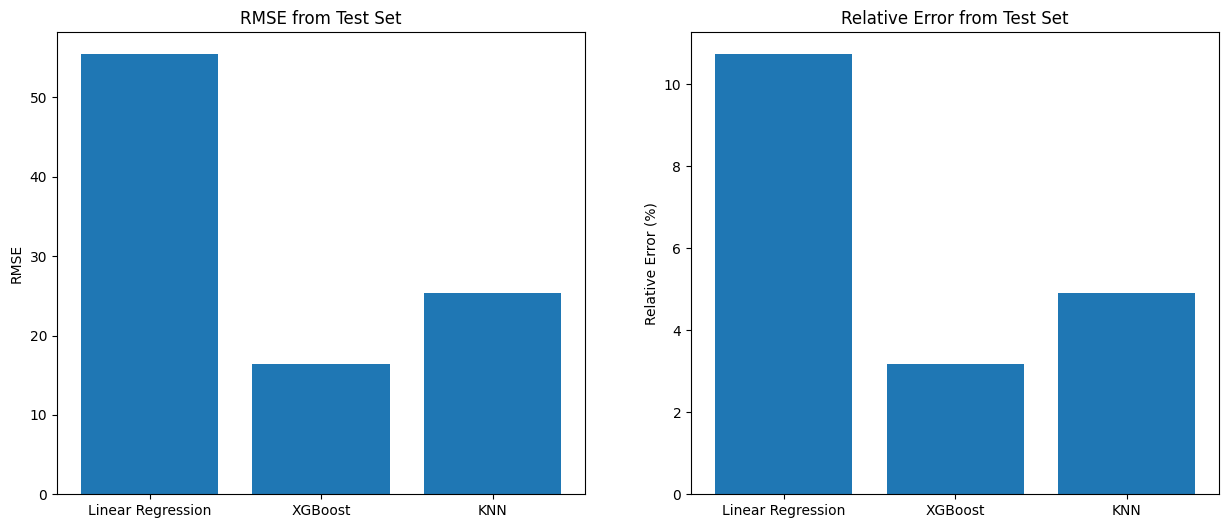

In [ ]:
models = ['Linear Regression', 'XGBoost', 'KNN']
rmse_values = [rmse_lr, rmse_xgb, rmse_knn]
relative_error_values = [relative_error_lr, relative_error_xgb, relative_error_knn]

fig, pos = plt.subplots(1, 2, figsize=(15, 6))

pos[0].bar(models, rmse_values)
pos[0].set_title("RMSE from Test Set")
pos[0].set_ylabel("RMSE")

pos[1].bar(models, relative_error_values)
pos[1].set_title("Relative Error from Test Set")
pos[1].set_ylabel("Relative Error (%)")

plt.show()

XGBoost performs better in terms of both RMSE and relative error, therefore: we have selected it as our final model.

###Export of the final models

In [ ]:
import joblib

joblib.dump(best_lr, 'lr_model.joblib')
joblib.dump(best_xgb, 'xgb_model.joblib')
joblib.dump(best_knn, 'knn_model.joblib')

['knn_model.joblib']

In [ ]:
from google.colab import files
!zip models.zip lr_model.joblib xgb_model.joblib knn_model.joblib

files.download('models.zip')

  adding: lr_model.joblib (deflated 27%)
  adding: xgb_model.joblib (deflated 70%)
  adding: knn_model.joblib (deflated 92%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>